### Import

In [83]:
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.cluster import KMeans
from tqdm import tqdm
from sklearn.metrics import silhouette_samples, silhouette_score

### Fonts

In [84]:
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Helvetica'}

### Create Random Data

In [158]:
np.random.seed(2650)
resolution = 9
k = 4
n_features = 2
n_samples = 800
noise = 2.5
X,y = make_blobs(n_samples=n_samples, n_features=n_features, centers=k, cluster_std=noise)
X[:,0] = X[:,0] - np.mean(X[:,0])
X[:,1] = X[:,1] - np.mean(X[:,1])

### Plot

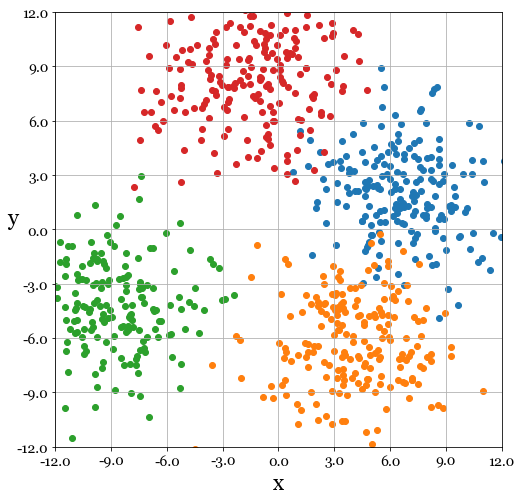

In [159]:
plt.figure(figsize=(8,8))
for idx in range(k):
    indices = np.where(y==idx)[0]
    plt.scatter(X[indices,0],X[indices,1])
plt.xlabel('x',fontsize=22,**csfont);
plt.ylabel('y',fontsize=22,**csfont,rotation=0);
plt.yticks(np.linspace(-12,12,resolution),labels=np.linspace(-12,12,resolution),fontsize=14,**csfont);
plt.xticks(np.linspace(-12,12,resolution),labels=np.linspace(-12,12,resolution),fontsize=14,**csfont);
plt.grid();
plt.savefig('../../assets/figures/017/kmeans-data.png',dpi=300,bbox_inches="tight")
plt.axis((-12,12,-12,12));

# Kmeans From Scratch

### Init
Initialize kmeans by picking random points as centroids

In [160]:
def initialize(X,k):
    idx = np.random.choice(X.shape[0], k, replace=False)
    centroids = X[idx,:]
    return centroids

### Expectation
Assign each point x in X to 1 of out k clusters by determining which centroid is cloest to it

In [161]:
def expectation(X,centroids):
    distances = cdist(X, centroids ,'euclidean')
    labels = np.argmin(distances,axis=1)
    return labels

### Maximization
Compute new centroids by taking the mean location of all the points of its members

In [162]:
def maximization(X,centroids,labels):
    for idx in range(k):
        indices = np.where(labels==idx)[0]
        centroids[idx,:] = centroids[idx,:]*0.8 + np.nanmean(X[indices,:],axis=0)*0.2
    return centroids

### K-Means EM Loop

In [163]:
no_iteration = 1
centroids = initialize(X,k)
centroids = (np.random.random((4,2))-0.5)
history = []
labelhistory = []
history.append(centroids.copy())
for i in range(30):
    labels = expectation(X,centroids)
    labelhistory.append(labels)
    centroids = maximization(X,centroids,labels)
    history.append(centroids.copy())
history = np.array(history)
labelhistory = np.array(labelhistory)

### Create Images to make a GIF

In [172]:
frame = 0
for frame in tqdm(range(30)):
    plt.figure(figsize=(8,8))
    for idx in range(k):
        indices = np.where(labelhistory[frame,:]==idx)[0]
        plt.scatter(X[indices,0],X[indices,1],zorder=100)
        path = history[:,idx,:]
        plt.scatter(path[frame,0],path[frame,1],s=250,color='w',linewidth=2,edgecolor='k',zorder=100)
    plt.xlabel('x',fontsize=22,**csfont);
    plt.ylabel('y',fontsize=22,**csfont,rotation=0);
    plt.yticks(np.linspace(-12,12,resolution),labels=np.linspace(-12,12,resolution),fontsize=14,**csfont);
    plt.xticks(np.linspace(-12,12,resolution),labels=np.linspace(-12,12,resolution),fontsize=14,**csfont);
    plt.grid()
    plt.axis((-12,12,-12,12))
    plt.savefig('../../assets/figures/017/kmeans-gif-' + str(frame) + '.png',dpi=300,bbox_inches="tight")     
    plt.close()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.37it/s]


### Predict using the centroids
When the algorithm is train we simply compute the closest centroid to a new point and assignn the point the cluster with that centroids 

In [165]:
y_pred = np.argmin(cdist(X,centroids),axis=1)

### Silhouette Plot and Metric

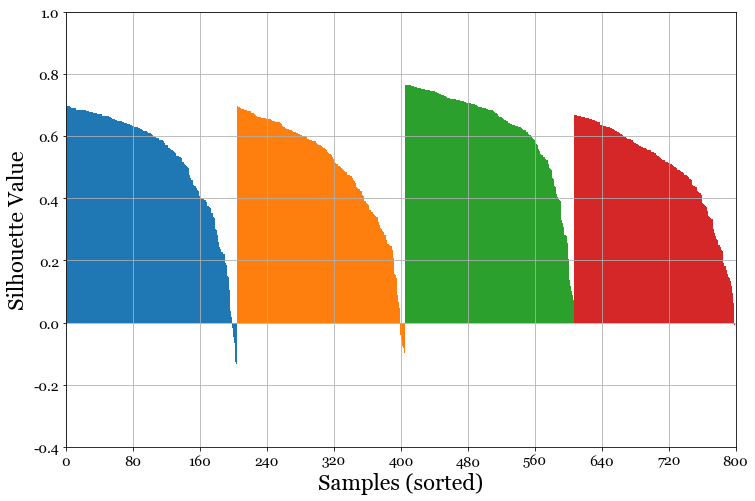

In [166]:
silhouette_avg = silhouette_score(X, y_pred)
sample_silhouette_values = silhouette_samples(X, y_pred)
silhouette_values = []
sorted_labels = []
for i in range(k):
    ith_cluster_silhouette_values = sample_silhouette_values[y_pred == i]
    ith_cluster_silhouette_values.sort()
    ith_cluster_silhouette_values = ith_cluster_silhouette_values[::-1]
    silhouette_values = silhouette_values + ith_cluster_silhouette_values.tolist()
    sorted_labels = sorted_labels + (np.zeros((len(ith_cluster_silhouette_values)))+i).astype(int).tolist()
silhouette_values = np.array(silhouette_values)
sorted_labels = np.array(sorted_labels)
plt.figure(figsize=(12,8))
for i in range(k):
    idx = np.where(sorted_labels == i)[0]
    plt.bar(idx,silhouette_values[idx],1)
plt.ylabel('Silhouette Value',fontsize=22,**csfont);
plt.xlabel('Samples (sorted)',fontsize=22,**csfont,rotation=0);
plt.yticks(np.linspace(-1,1,11),labels=np.round(np.linspace(-1,1,11),2),fontsize=14,**csfont);
plt.xticks(np.linspace(0,len(silhouette_values),11),
           labels=np.linspace(0,len(silhouette_values),11).astype(int),fontsize=14,**csfont);
plt.grid()
plt.axis((0,len(y_pred),-0.4,1))
plt.savefig('../../assets/figures/017/kmeans-silhouette.png',dpi=300,bbox_inches="tight") 

### Visualize the clusters and the path of the cluster centroids

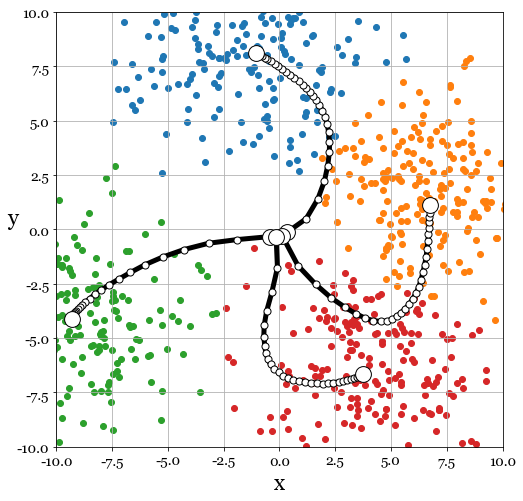

In [167]:
plt.figure(figsize=(8,8))
for idx in range(k):
    indices = np.where(y_pred==idx)[0]
    plt.scatter(X[indices,0],X[indices,1])
for idx in range(4):
    path = history[:,idx,:]
    plt.scatter(path[0,0],path[0,1],s=250,color='w',edgecolor='k',zorder=100)
    plt.scatter(path[:,0],path[:,1],s=50,facecolor='w',edgecolor='k',zorder=10)
    plt.plot(path[:,0],path[:,1],'k',linewidth=5)
    plt.scatter(path[-1,0],path[-1,1],s=250,facecolor='w',edgecolor='k',zorder=10)
plt.xlabel('x',fontsize=22,**csfont);
plt.ylabel('y',fontsize=22,**csfont,rotation=0);
plt.yticks(np.linspace(-10,10,resolution),labels=np.linspace(-10,10,resolution),fontsize=14,**csfont);
plt.xticks(np.linspace(-10,10,resolution),labels=np.linspace(-10,10,resolution),fontsize=14,**csfont);
plt.grid()
plt.axis((-10,10,-10,10))
plt.savefig('../../assets/figures/017/kmeans-fit.png',dpi=300,bbox_inches="tight") 

# kmeans with scikit

In [168]:
kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
y_pred = kmeans.labels_

### Kmean result

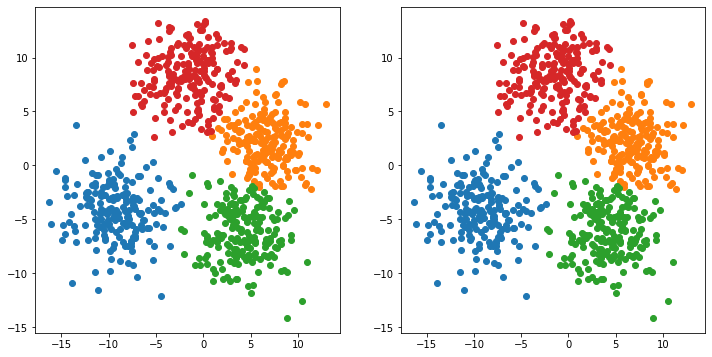

In [169]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
for idx in range(k):
    indices = np.where(y_pred==idx)[0]
    plt.scatter(X[indices,0],X[indices,1])

#Ground Thruth
plt.subplot(1,2,2)
for idx in range(k):
    indices = np.where(y_pred==idx)[0]
    plt.scatter(X[indices,0],X[indices,1])